In [2]:
pip install --upgrade scikit-learn==1.3.2 imbalanced-learn==0.12.4


  Using cached scikit_learn-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 92.3 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 13.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# import system libs 
import os
import time
import shutil
import itertools

# import data handling tools 
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

2025-09-26 17:55:30.491937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758909330.888895      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758909330.997046      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules loaded


In [4]:
data_dir = '/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv'
data = pd.read_csv(data_dir)
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [34]:
Label = data["label"]
Data = data.drop(columns=["label"]) 

In [35]:
from imblearn.over_sampling import RandomOverSampler 

oversample = RandomOverSampler()
Data, Label  = oversample.fit_resample(Data, Label)
Data = np.array(Data).reshape(-1, 28, 28, 3)
print('Shape of Data :', Data.shape)

Shape of Data : (46935, 28, 28, 3)


In [36]:
Label = np.array(Label)
Label

array([2, 2, 2, ..., 6, 6, 6])

In [37]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

In [38]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(Data , Label , test_size = 0.2 , random_state =0)

In [39]:
print(f'X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}\ny_test shape: {y_test.shape}')

X_train shape: (37548, 28, 28, 3)
X_test shape: (9387, 28, 28, 3)
y_train shape: (37548,)
y_test shape: (9387,)


In [40]:

from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [41]:
datagen = ImageDataGenerator(rescale=(1./255)
                             
                             )

testgen = ImageDataGenerator(rescale=(1./255))

In [42]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.5
                                            , min_lr=0.00001)

In [43]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, models

 #Input Layer
inputs = layers.Input(shape=(28, 28, 3))

# ======================
# First Block
# ======================
x = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(inputs)
x = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(x)
x = layers.MaxPooling2D((2, 2))(x)

# ======================
# Second Block
# ======================
x = layers.Conv2D(256, (3, 3), activation='relu', padding="same")(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding="same")(x)
x = layers.MaxPooling2D((2, 2))(x)

# ======================
# Parallel Branches
# ======================

# Branch 1
branch1 = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(x)
branch1 = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(branch1)

# Branch 2
branch2 = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(x)
branch2 = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(branch2)

# Concatenate feature maps
concat = layers.Concatenate()([branch1, branch2])

# ======================
# Fully Connected Layers
# ======================
flatten = layers.Flatten()(concat)
dense1 = layers.Dense(64, activation='relu')(flatten)
outputs = layers.Dense(7, activation='softmax')(dense1)
# Build Model
model = models.Model(inputs, outputs)
model.summary()


model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 28, 28, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 28, 28,    │      3,584 │ input_layer_4[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 28, 28,    │    147,584 │ conv2d_30[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 14, 14,    │          0 │ conv2d_31[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 14, 14,    │    295,168 │ max_pooling2d_8[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 14, 14,    │    590,080 │ conv2d_32[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 7, 7, 256) │          0 │ conv2d_33[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 7, 7, 64)  │    147,520 │ max_pooling2d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 7, 7, 64)  │    147,520 │ max_pooling2d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 7, 7, 64)  │     36,928 │ conv2d_34[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 7, 7, 64)  │     36,928 │ conv2d_36[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 7, 7, 128) │          0 │ conv2d_35[0][0],  │
│ (Concatenate)       │                   │            │ conv2d_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 6272)      │          0 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │    401,472 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 7)         │        455 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,807,239 (6.89 MB)

 Trainable params: 1,807,239 (6.89 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 28, 28, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 28, 28,    │      3,584 │ input_layer_4[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 28, 28,    │    147,584 │ conv2d_30[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 14, 14,    │          0 │ conv2d_31[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 14, 14,    │    295,168 │ max_pooling2d_8[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 14, 14,    │    590,080 │ conv2d_32[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 7, 7, 256) │          0 │ conv2d_33[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 7, 7, 64)  │    147,520 │ max_pooling2d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 7, 7, 64)  │    147,520 │ max_pooling2d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 7, 7, 64)  │     36,928 │ conv2d_34[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 7, 7, 64)  │     36,928 │ conv2d_36[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 7, 7, 128) │          0 │ conv2d_35[0][0],  │
│ (Concatenate)       │                   │            │ conv2d_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 6272)      │          0 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │    401,472 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 7)         │        455 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,807,239 (6.89 MB)

 Trainable params: 1,807,239 (6.89 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
from tensorflow.keras import optimizers
model.compile(loss='categorical_crossentropy', # Changed loss to categorical_crossentropy
             optimizer=optimizers.Adam(learning_rate=1e-4), # Corrected optimizer access and learning_rate
              metrics=['acc'])

In [46]:
history = model.fit(X_train ,
                    y_train ,
                    epochs=30 ,
                    batch_size=128,
                    validation_data=(X_test , y_test)
                    )

Epoch 1/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 26s 71ms/step - acc: 0.9050 - loss: 0.2913 - val_acc: 0.9319 - val_loss: 0.2150
Epoch 2/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - acc: 0.9544 - loss: 0.1537 - val_acc: 0.9484 - val_loss: 0.1578
Epoch 3/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - acc: 0.9698 - loss: 0.1047 - val_acc: 0.9667 - val_loss: 0.1200
Epoch 4/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - acc: 0.9809 - loss: 0.0722 - val_acc: 0.9700 - val_loss: 0.1012
Epoch 5/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - acc: 0.9851 - loss: 0.0530 - val_acc: 0.9657 - val_loss: 0.1225
Epoch 6/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - acc: 0.9880 - loss: 0.0438 - val_acc: 0.9687 - val_loss: 0.1037
Epoch 7/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - acc: 0.9933 - loss: 0.0269 - val_acc: 0.9728 - val_loss: 0.0984
Epoch 8/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - acc: 0.9919 - loss: 0.0301 - val_acc: 0.9697 - val_loss: 0.1194
Epoch 9/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 

In [51]:
def plot_training(hist):
    tr_acc = hist.history['acc']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_acc']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()

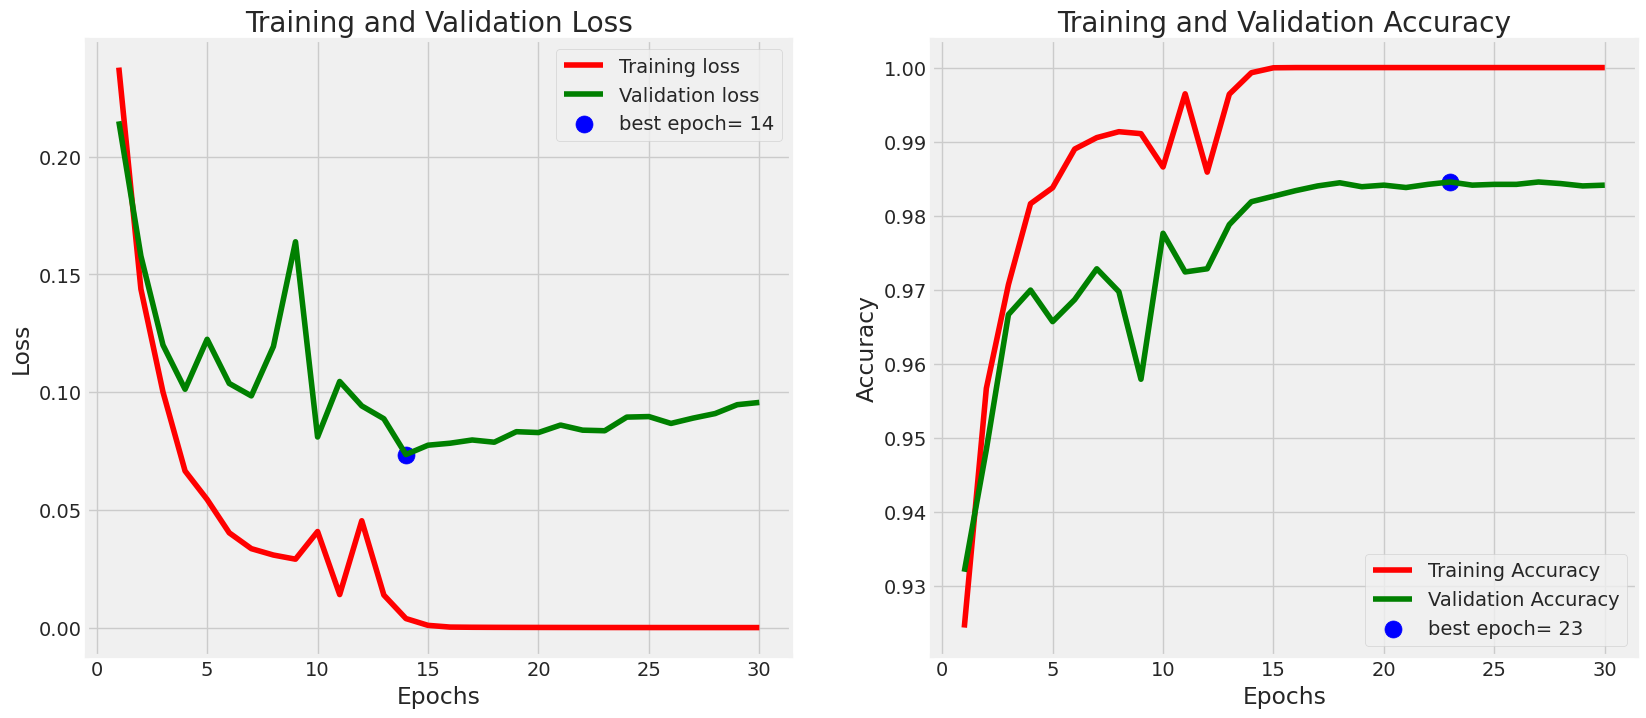

In [52]:
plot_training(history)

In [53]:
train_score = model.evaluate(X_train, y_train, verbose= 1)
test_score = model.evaluate(X_test, y_test, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1174/1174 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - acc: 1.0000 - loss: 1.2475e-05
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.9815 - loss: 0.1098
Train Loss:  1.2677146514761262e-05
Train Accuracy:  1.0
--------------------
Test Loss:  0.09563992917537689
Test Accuracy:  0.9841269850730896


In [54]:
y_true = np.array(y_test)
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred , axis=1)
y_true = np.argmax(y_true , axis=1)

294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


In [55]:
classes_labels = []
for key in classes.keys():
    classes_labels.append(key)

print(classes_labels)

[4, 6, 2, 1, 5, 0, 3]


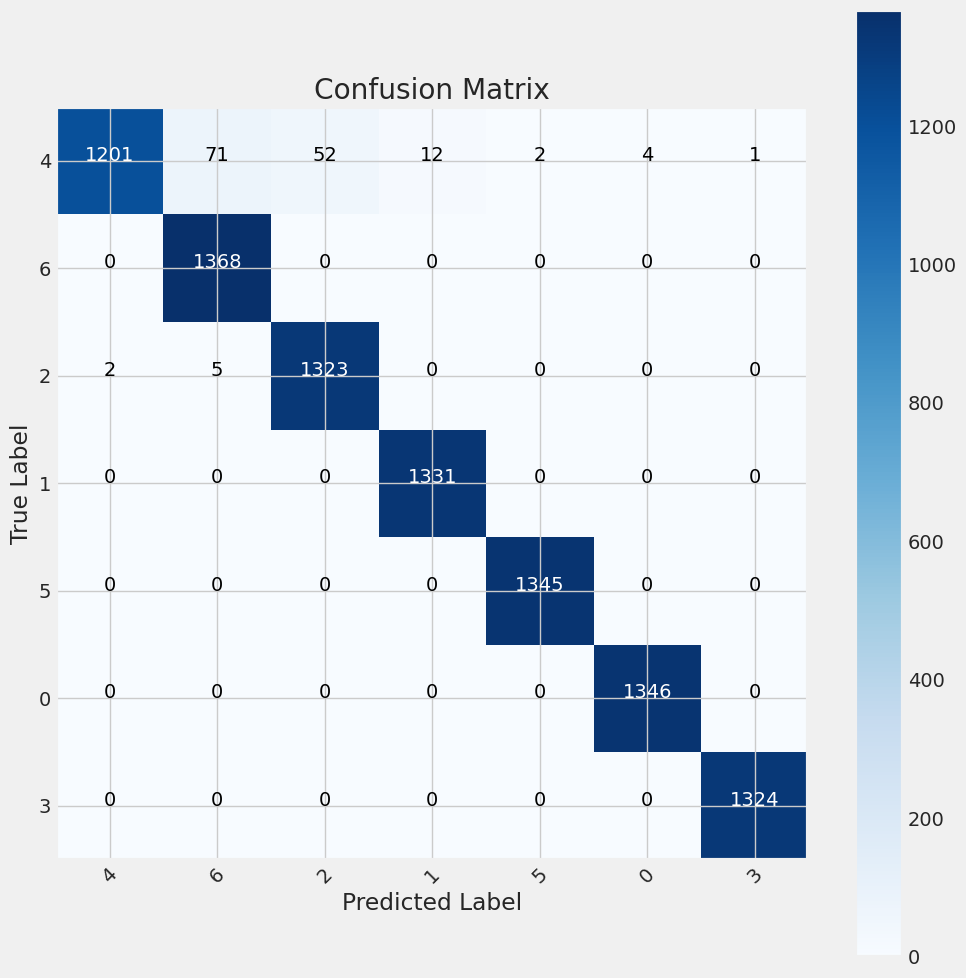

In [56]:
# Confusion matrix
cm = cm = confusion_matrix(y_true, y_pred, labels=classes_labels)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [57]:
#Save the model
model.save('Skin Cancer.h5')

In [61]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true, y_pred, target_names=[
    'akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel'
])

print(report)


              precision    recall  f1-score   support

       akiec       1.00      1.00      1.00      1346
         bcc       0.99      1.00      1.00      1331
         bkl       0.96      0.99      0.98      1330
          df       1.00      1.00      1.00      1324
          nv       1.00      0.89      0.94      1343
        vasc       1.00      1.00      1.00      1345
         mel       0.95      1.00      0.97      1368

    accuracy                           0.98      9387
   macro avg       0.98      0.98      0.98      9387
weighted avg       0.98      0.98      0.98      9387



In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model) 
tflite_model = converter.convert() 

print("model converted")

# Save the model. 
with open('Skin.tflite', 'wb') as f:
    f.write(tflite_model)